In [15]:
import os
import numpy as np
from matplotlib import pylab as plt

import pandas as pd
import math
import random
from functools import reduce
from itertools import islice
from sklearn.metrics import roc_auc_score, f1_score

from scipy.stats import wilcoxon
import statistics
plt.rcParams['figure.figsize'] = (8,6)

In [2]:
def load_master_file(path, number_of_bins=1000):
    mol_all = np.loadtxt(path, dtype="U25")  # Get master file in as numpy array

    mol_ids = np.unique(mol_all[:, 0])  # Trim duplicate filename rows, store unique filenames
    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in mol_ids).
    intensities = pd.DataFrame(0.0, index=mol_ids, columns=range(number_of_bins), dtype=float)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in mol_all:
        intensities.at[row[0], float(row[1]) - 1] = float(row[2])

    return intensities

def load_fingerprints_master(path, number_of_rows=0):
    BITS = 307  # Total number of bits in fingerprint
    
    # number_of_rows to skip, e.g. headers
    fp_all = np.loadtxt(path, dtype="U25", skiprows=number_of_rows)  # Get master file as numpy array of Strings
    fp_ids = np.unique(fp_all[:, 0])  # Trim duplicate filename rows, store unique filenames

    # Construct empty Pandas dataframe of correct size.
    # Number of rows is equal to the number of unique molecules (found in fp_ids).
    fingerprints = pd.DataFrame(0, index=fp_ids, columns=range(BITS), dtype=int)

    # Populate the dataframe using each molecule's filename to place data in the correct row.
    for row in fp_all:
        fingerprints.at[row[0], int(row[1])] = int(row[2])

    return fingerprints

def load_fingerprint_legend():
    fingerprint_legend = []
    # Open file containing substructure names
    with open(fingerprints_names_path, 'r') as f:
        # Add each name to the list of substructure names
        lines = list(islice(f, 0, None))
        for line in lines:
            fingerprint_legend.append(line[:-1])
    return fingerprint_legend

In [3]:
def generate_dataset():
    train, validate, test = np.split(spectra.sample(frac=1), [int(.6*len(spectra)), int(.8*len(spectra))])
    train_fingerprints = fingerprints[fingerprints.index.isin(train.index)]
    validate_fingerprints = fingerprints[fingerprints.index.isin(validate.index)]
    test_fingerprints = fingerprints[fingerprints.index.isin(test.index)]

    train.sort_index(inplace=True)
    validate.sort_index(inplace=True)
    test.sort_index(inplace=True)
    train_fingerprints.sort_index(inplace=True)
    validate_fingerprints.sort_index(inplace=True)
    test_fingerprints.sort_index(inplace=True)

    return train, train_fingerprints, validate, validate_fingerprints, test, test_fingerprints

In [4]:
from keras.layers import Input, Dense
from keras.models import Model,Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.optimizers import SGD

def just_fragments_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def just_shifts_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

def fragments_shifts_model(input_to_network, output):
    class_model = Sequential()
    class_model.add(Dense(500, input_dim=input_to_network.shape[1], kernel_initializer='normal', activation='relu'))
    class_model.add(Dense(output.shape[1],kernel_initializer='normal',activation = 'sigmoid'))
    class_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return class_model

Using TensorFlow backend.


In [5]:
def calc_peak_differences(spec):
    non_zero_peaks = list(np.where(spec>0)[0])
    peak_differences = [(abs(i-j), (spec[i]+spec[j]/2.0)) for i in non_zero_peaks for j in non_zero_peaks if i != j and j > i]
    
    return peak_differences

In [6]:
def load_shift_bins(intensities):
    shift_bins = pd.DataFrame(0.0, index = intensities.index, columns=range(intensities.shape[1]), dtype=float)
    for index, spec in enumerate(intensities.values):
        peak_differences = calc_peak_differences(spec)
        mol_name = intensities.index[index]
        for shift, average_intensity in peak_differences:
            shift_bins.at[mol_name, shift-1] += average_intensity
        shift_bins.loc[mol_name].div(np.amax(intensities.loc[mol_name].values)).mul(999)
    return shift_bins

In [7]:
def compute_auc(indexes, true, pred):
    auc_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = roc_auc_score(fp_true, fp_pred)
            auc_scores.append((index, score))
        else:
            auc_scores.append((index, 0.0))
            
    print("Compute AUC done")
    return auc_scores

def compute_f1(indexes, true, pred):
    f1_scores = []
    
    for i, index in enumerate(indexes):
        nonzero_vals = np.count_nonzero(true[:, i]) # Count number of nonzero values
        if nonzero_vals > 0 and nonzero_vals < true[:, i].size: # If there are no 1s or no 0s, can't compute.
            fp_true = true[:, i]
            fp_pred = pred[:, i]
            score = f1_score(fp_true, fp_pred, average='micro')
            f1_scores.append((index, score))
        else:
            f1_scores.append((index, 0.0))
            
    print("Compute F1 done")
    return f1_scores

In [8]:
def train_fragments_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    auc_path = path + "exp_{}_fragments_only_aucs.csv".format(iteration_index)
    f1_path = path + "exp_{}_fragments_only_f1_scores.csv".format(iteration_index)
    print(train.shape)
    
    x_train_spec = np.log(train.values + 1)
    x_validate_spec = np.log(validate.values + 1)
    x_test_spec = np.log(test.values + 1)
    
    mod = just_fragments_model(x_train_spec, train_fingerprints)
    mod.fit(x_train_spec[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(x_validate_spec, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(x_test_spec)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1
    
    stats = compute_auc(test_fingerprints.columns.tolist(), test_fingerprints.values, predicted)
    f1_stats = compute_f1(fingerprints.columns.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:    
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")

    with open(f1_path, 'w') as f:
        for fp_id, f1_score in stats:
            f.write(str(fp_id) + "," + str(f1_score) + "\n")
            
def train_shifts_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    auc_path = path + "exp_{}_shifts_only_aucs.csv".format(iteration_index)
    f1_path = path + "exp_{}_shifts_only_f1_scores.csv".format(iteration_index)
    print(train.shape)
    
    train_shift_bins = load_shift_bins(train)
    validate_shift_bins = load_shift_bins(validate)
    test_shift_bins = load_shift_bins(test)

    x_train_shifts = np.log(train_shift_bins.values + 1)
    x_validate_shifts = np.log(validate_shift_bins.values + 1)
    x_test_shifts = np.log(test_shift_bins.values + 1)
    
    mod = just_shifts_model(x_train_shifts, train_fingerprints)
    mod.fit(x_train_shifts[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(x_validate_shifts, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(x_test_shifts)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1
    
    stats = compute_auc(test_fingerprints.columns.tolist(), test_fingerprints.values, predicted)
    f1_stats = compute_f1(fingerprints.columns.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:    
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")
            
    with open(f1_path, 'w') as f:
        for fp_id, f1_score in stats:
            f.write(str(fp_id) + "," + str(f1_score) + "\n")

def train_fragments_and_shifts_diff_splits(path, iteration_index):
    epochs = 100
    N,M = train.shape
    shuffle_order = np.random.permutation(N)
    auc_path = path + "exp_{}_fragments_and_shifts_aucs.csv".format(iteration_index)
    f1_path = path + "exp_{}_fragments_and_shifts_f1_scores.csv".format(iteration_index)
    train_combined_df_path = path + "exp_{}_train_combined_df.pkl".format(iteration_index)
    validate_combined_df_path = path + "exp_{}_validate_combined_df.pkl".format(iteration_index)
    test_combined_df_path = path + "exp_{}_test_combined_df.pkl".format(iteration_index)
    
    print(train.shape)
    train_shift_bins = load_shift_bins(train)
    validate_shift_bins = load_shift_bins(validate)
    test_shift_bins = load_shift_bins(test)
    
    train_combined_before_normalise = pd.concat((train, train_shift_bins), axis=1)
    validate_combined_before_normalise = pd.concat((validate, validate_shift_bins), axis=1)
    test_combined_before_normalise = pd.concat((test, test_shift_bins), axis=1)
    
    train_combined_before_normalise.columns = range(2000)
    validate_combined_before_normalise.columns = range(2000)
    test_combined_before_normalise.columns = range(2000)
    
    train_combined_before_normalise.to_pickle(train_combined_df_path)
    validate_combined_before_normalise.to_pickle(validate_combined_df_path)
    test_combined_before_normalise.to_pickle(test_combined_df_path)
    
    x_train_spec = np.log(train.values + 1)
    x_validate_spec = np.log(validate.values + 1)
    x_test_spec = np.log(test.values + 1)
    
    x_train_shifts = np.log(train_shift_bins.values + 1)
    x_validate_shifts = np.log(validate_shift_bins.values + 1)
    x_test_shifts = np.log(test_shift_bins.values + 1)
    
    train_combined = np.concatenate((x_train_spec,x_train_shifts),axis=1)
    validate_combined = np.concatenate((x_validate_spec,x_validate_shifts),axis=1)
    test_combined = np.concatenate((x_test_spec,x_test_shifts),axis=1)
    
    mod = fragments_shifts_model(train_combined, train_fingerprints)
    mod.fit(train_combined[shuffle_order,:],train_fingerprints.values[shuffle_order,:],epochs=epochs,
            validation_data=(validate_combined, validate_fingerprints.values),verbose=0)

    predicted = mod.predict(test_combined)
    prediction = np.zeros((predicted.shape))
    prediction[predicted > 0.5] = 1
    
    stats = compute_auc(test_fingerprints.columns.tolist(), test_fingerprints.values, predicted)
    f1_stats = compute_f1(fingerprints.columns.tolist(), test_fingerprints.values, prediction)
    
    with open(auc_path, 'w') as f:
        for fp_id, auc in stats:
            f.write(str(fp_id) + "," + str(auc) + "\n")
            
    with open(f1_path, 'w') as f:
        for fp_id, f1_score in stats:
            f.write(str(fp_id) + "," + str(f1_score) + "\n")

In [9]:
spec_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Data.txt"
fingerprints_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Final Fingerprints.txt"

spectra = load_master_file(spec_path)
fingerprints = load_fingerprints_master(fingerprints_path)

for idx, value in fingerprints.astype(bool).sum(axis=0).iteritems():
    if value < 10:
        fingerprints.drop(columns=[idx], inplace=True)

In [10]:
relevant_fingerprints = fingerprints.columns

In [11]:
fingerprints_names_path = "G:\\Dev\\Data\\1000\\GNPS Python Master\\Fingerprint Legend.txt"
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\"

In [11]:
for i in range(0, 10):
    print(i)
    train, train_fingerprints, validate, validate_fingerprints, test, test_fingerprints = generate_dataset() 
    train_fragments_diff_splits(path, i)
    train_shifts_diff_splits(path, i)
    train_fragments_and_shifts_diff_splits(path, i)

0
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
1
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
2
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
3
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
4
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
5
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
6
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
(3462, 1000)
Compute AUC done
Compute F1 done
7
(3462, 1000)
Compu

In [12]:
fingerprint_names = load_fingerprint_legend()

In [13]:
def benjamini_fdr(pvalues):
    num_tests = len(pvalues)
    pvalues.sort(key=lambda x: float(x[1])) # Arrange from smallest to highest
    rank = range(1, num_tests+1)
    pvalues_with_rank = [(pvalue[0], pvalue[1], rank[index]) for index, pvalue in enumerate(pvalues)]
    new_values = []
    
    for fingerprint, pvalue, rank in pvalues_with_rank:
        critical_value = (rank / num_tests) * 0.05 # fdr of 0.05 is used
        new_values.append((fingerprint, pvalue, rank, critical_value))
    
        max_pvalue_less_than_crit = 0.0
        max_pvalue_less_than_crit_rank = 0
    
        for fingerprint, pvalue, rank, critical_value in new_values:
            if pvalue > max_pvalue_less_than_crit and pvalue < critical_value:
                max_pvalue_less_than_crit = pvalue
                max_pvalue_less_than_crit_rank = rank
    
    return new_values, max_pvalue_less_than_crit_rank

In [16]:
path = "G:\\Dev\\Data\\Shift vs No Shifts Experiments (fingerprints) 2\\"

shift_only_auc_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("shifts_only_aucs.csv")]
fragment_only_auc_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_only_aucs.csv")]
combined_auc_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_and_shifts_aucs.csv")]

shift_only_f1_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("shifts_only_f1_scores.csv")]
fragment_only_f1_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_only_f1_scores.csv")]
combined_f1_filenames = [file[:-4][:5] for file in os.listdir(path) if file.endswith("fragments_and_shifts_f1_scores.csv")]

shift_auc_df = pd.DataFrame(0.0, index=shift_only_auc_filenames, columns=relevant_fingerprints, dtype=float)
fragment_auc_df = pd.DataFrame(0.0, index=fragment_only_auc_filenames, columns=relevant_fingerprints, dtype=float)
combined_auc_df = pd.DataFrame(0.0, index=combined_auc_filenames, columns=relevant_fingerprints, dtype=float)

shift_f1_df = pd.DataFrame(0.0, index=shift_only_f1_filenames, columns=relevant_fingerprints, dtype=float)
fragment_f1_df = pd.DataFrame(0.0, index=fragment_only_f1_filenames, columns=relevant_fingerprints, dtype=float)
combined_f1_df = pd.DataFrame(0.0, index=combined_f1_filenames, columns=relevant_fingerprints, dtype=float)

shift_mean_aucs = []
fragment_mean_aucs = []
combined_mean_aucs = []

# Load AUC scores

for file in shift_only_auc_filenames:
    filepath = os.path.join(path, file + "_shifts_only_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            shift_auc_df.at[file, int(fingerprint)] = float(auc[:-1])
            
for file in fragment_only_auc_filenames:
    filepath = os.path.join(path, file + "_fragments_only_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            fragment_auc_df.at[file, int(fingerprint)] = float(auc[:-1])
            
for file in combined_auc_filenames:
    filepath = os.path.join(path, file + "_fragments_and_shifts_aucs.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, auc = line.split(",")
            combined_auc_df.at[file, int(fingerprint)] = float(auc[:-1])

# Save mean AUC scores
for i in shift_auc_df.columns:
    shift_mean_auc = statistics.mean(shift_auc_df[i].tolist())
    fragment_mean_auc = statistics.mean(fragment_auc_df[i].tolist())
    combined_mean_auc = statistics.mean(combined_auc_df[i].tolist())
    shift_mean_aucs.append((i, shift_mean_auc))
    fragment_mean_aucs.append((i, fragment_mean_auc))
    combined_mean_aucs.append((i, combined_mean_auc))
    
# Load F1 scores

for file in shift_only_auc_filenames:
    filepath = os.path.join(path, file + "_shifts_only_f1_scores.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, f1 = line.split(",")
            shift_f1_df.at[file, int(fingerprint)] = float(f1[:-1])
    
for file in fragment_only_auc_filenames:
    filepath = os.path.join(path, file + "_fragments_only_f1_scores.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, f1 = line.split(",")
            fragment_f1_df.at[file, int(fingerprint)] = float(f1[:-1])
            
for file in combined_auc_filenames:
    filepath = os.path.join(path, file + "_fragments_and_shifts_f1_scores.csv")
    with open(filepath, 'r') as f:
        for line in f:
            fingerprint, f1 = line.split(",")
            combined_f1_df.at[file, int(fingerprint)] = float(f1[:-1])

In [22]:
shift_mean_aucs.sort(key=lambda x: float(x[1]))
fragment_mean_aucs.sort(key=lambda x: float(x[1]))
combined_mean_aucs.sort(key=lambda x: float(x[1]))

shift_mean_auc_scores = [fingerprint[1] for fingerprint in shift_mean_aucs]
fragment_mean_auc_scores = [fingerprint[1] for fingerprint in fragment_mean_aucs]
combined_mean_auc_scores = [fingerprint[1] for fingerprint in combined_mean_aucs]

Trend comparison

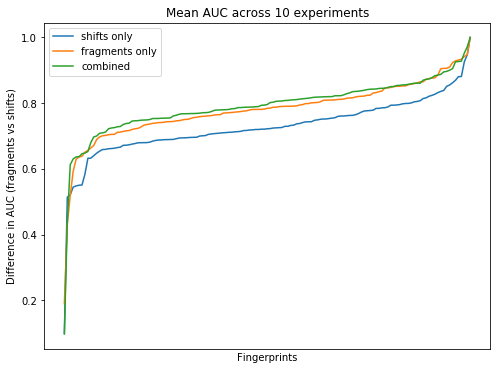

In [23]:
plt.title("Mean AUC across 10 experiments")
plt.plot(range(0, len(shift_mean_auc_scores)), shift_mean_auc_scores, label="shifts only")
plt.plot(range(0, len(fragment_mean_auc_scores)), fragment_mean_auc_scores, label="fragments only")
plt.plot(range(0, len(combined_mean_auc_scores)), combined_mean_auc_scores, label="combined")
plt.legend()
plt.xticks([])
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (fragments vs shifts)")
plt.show()

Compare fragments against shifts

AUC

In [27]:
difference_auc_filenames = ["exp_{}".format(i) for i in range(10)]
difference_auc_df = pd.DataFrame(0.0, index=difference_auc_filenames, columns=relevant_fingerprints, dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_auc_df.columns:
    base_aucs = shift_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = fragment_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_auc_df[i] = fragment_auc_df[i] - shift_auc_df[i]
    difference = [difference for difference in difference_auc_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    pvalues.append((i, t_test.pvalue))

In [28]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

In [29]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [30]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

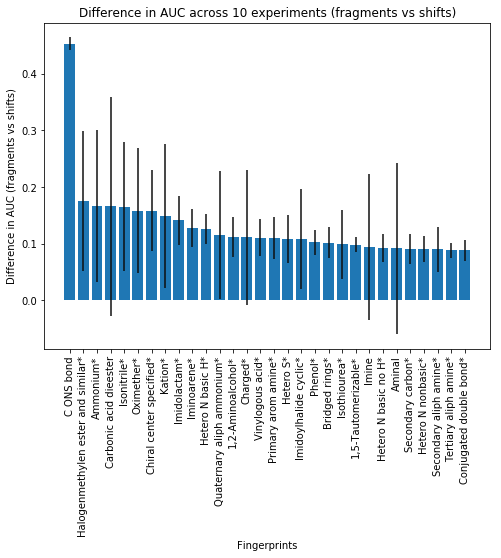

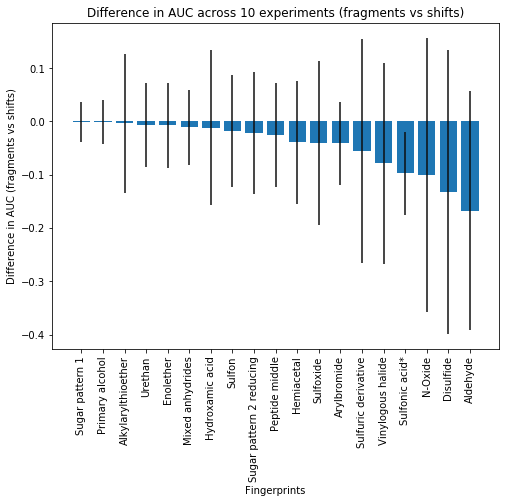

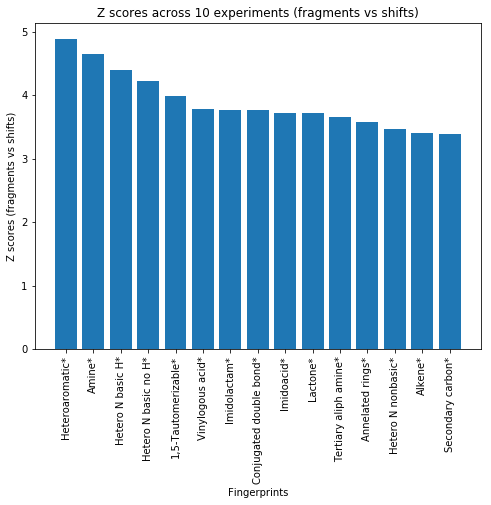

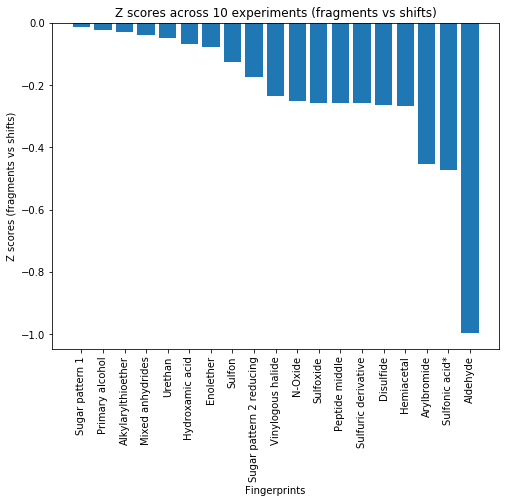

73 significantly different mean aucs
72 significantly positive difference
1 significantly negative difference


In [31]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in AUC across 10 experiments (fragments vs shifts)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (fragments vs shifts)")
plt.show()

plt.title("Difference in AUC across 10 experiments (fragments vs shifts)")
plt.bar(fingerprints[120:], score_differences[120:], align='center', yerr=std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(z_fingerprints[120:], z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))


F1

In [35]:
difference_f1_filenames = ["exp_{}".format(i) for i in range(10)]
difference_f1_df = pd.DataFrame(0.0, index=difference_f1_filenames, columns=relevant_fingerprints, dtype=float)
f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i in combined_f1_df.columns:
    base_aucs = shift_f1_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = fragment_f1_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_f1_df[i] = fragment_f1_df[i] - shift_f1_df[i]
    difference = [difference for difference in difference_f1_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    f1_pvalues.append((i, t_test.pvalue))

In [36]:
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

f1_differences.reverse()
f1_z_differences.reverse()

In [37]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [38]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

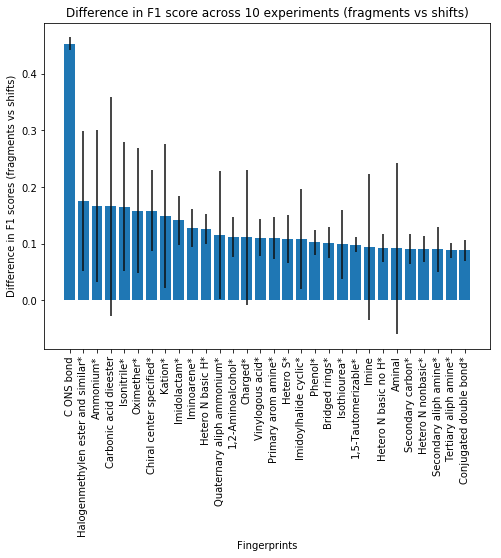

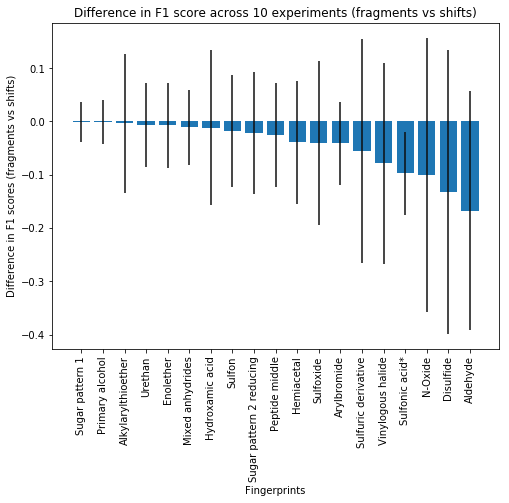

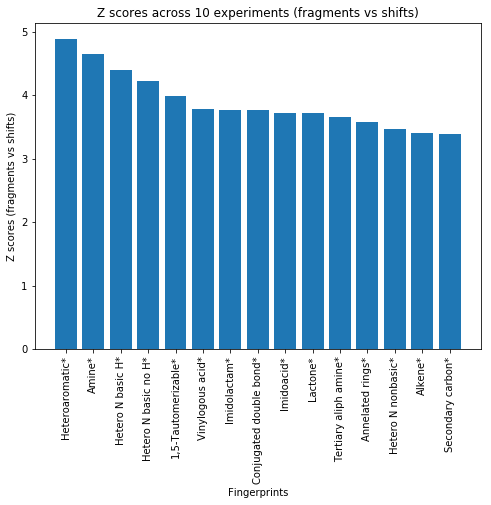

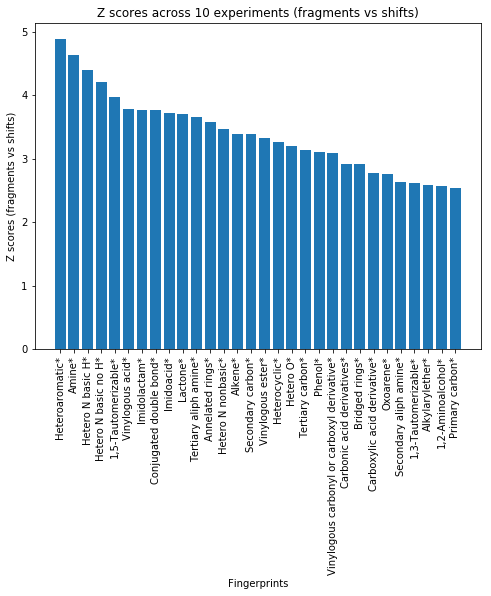

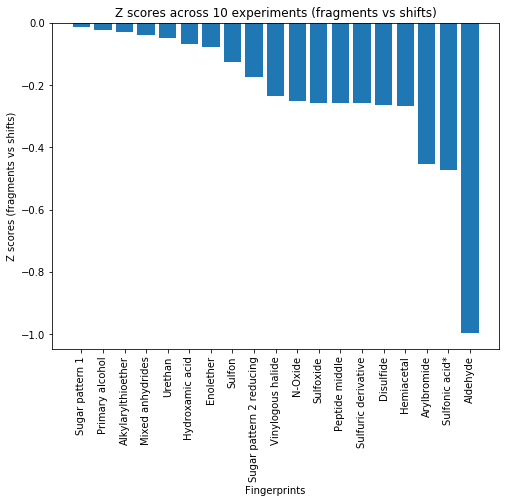

73 significantly different mean f1 scores
72 significantly positive difference
1 significantly negative difference


In [39]:
error_config = {'ecolor': '0.05'}

plt.title("Difference in F1 score across 10 experiments (fragments vs shifts)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (fragments vs shifts)")
plt.show()

plt.title("Difference in F1 score across 10 experiments (fragments vs shifts)")
plt.bar(f1_fingerprints[120:], f1_score_differences[120:], align='center', yerr=f1_std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(f1_z_fingerprints[:30], f1_z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (fragments vs shifts)")
plt.bar(f1_z_fingerprints[120:], f1_z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (fragments vs shifts)")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare combined with fragments only

AUC

In [64]:
difference_auc_filenames = ["exp_{}".format(i) for i in range(10)]
difference_auc_df = pd.DataFrame(0.0, index=difference_auc_filenames, columns=relevant_fingerprints, dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_auc_df.columns:
    base_aucs = fragment_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = combined_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_auc_df[i] = combined_auc_df[i] - fragment_auc_df[i]
    difference = [difference for difference in difference_auc_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    pvalues.append((i, t_test.pvalue))

In [65]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

In [66]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [67]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

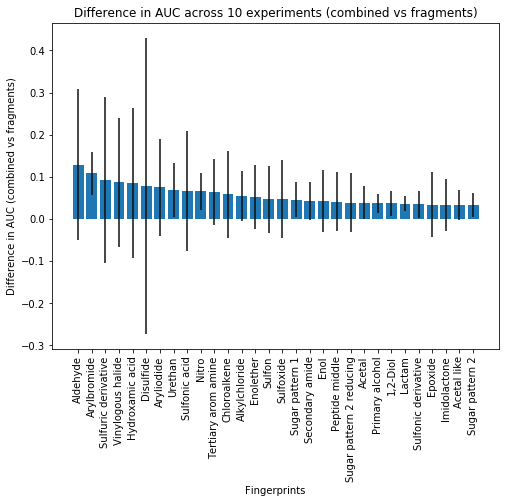

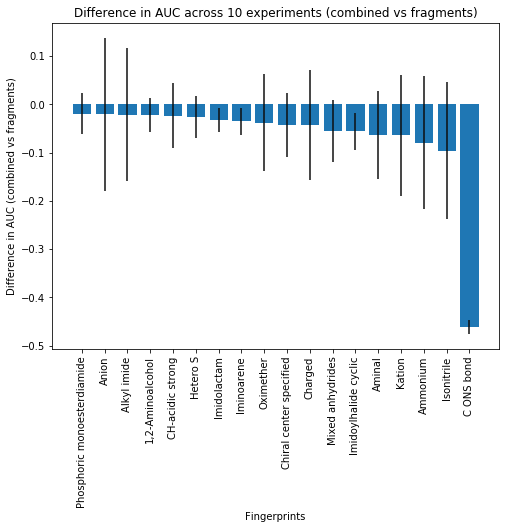

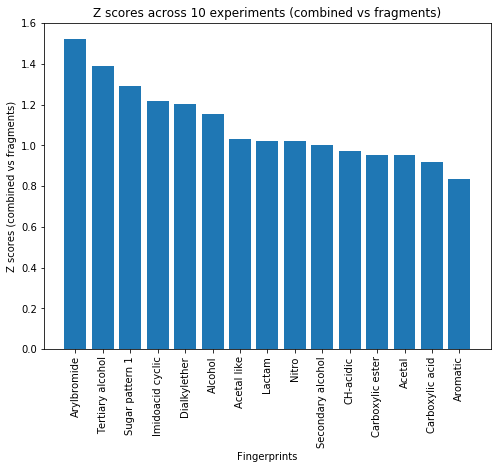

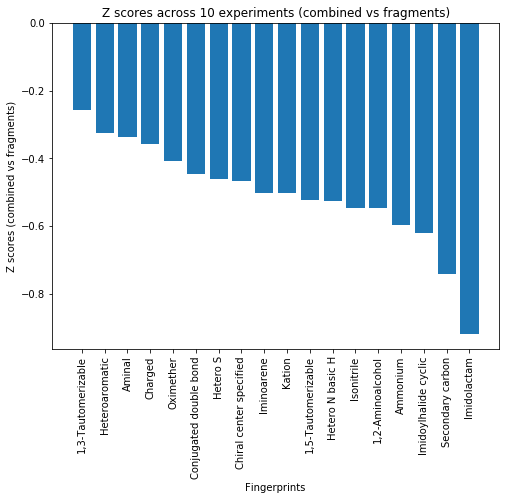

0 significantly different mean aucs
0 significantly positive difference
0 significantly negative difference


In [68]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (combined vs fragments)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs fragments)")
plt.show()

plt.title("Difference in AUC across 10 experiments (combined vs fragments)")
plt.bar(fingerprints[120:], score_differences[120:], align='center', yerr=std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(z_fingerprints[120:], z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))


F1

In [48]:
difference_f1_filenames = ["exp_{}".format(i) for i in range(10)]
difference_f1_df = pd.DataFrame(0.0, index=difference_f1_filenames, columns=relevant_fingerprints, dtype=float)
f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i in combined_f1_df.columns:
    base_aucs = fragment_f1_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = combined_f1_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_f1_df[i] = combined_f1_df[i] - fragment_f1_df[i]
    difference = [difference for difference in difference_f1_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    f1_pvalues.append((i, t_test.pvalue))

In [49]:
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

f1_differences.reverse()
f1_z_differences.reverse()

In [50]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [51]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

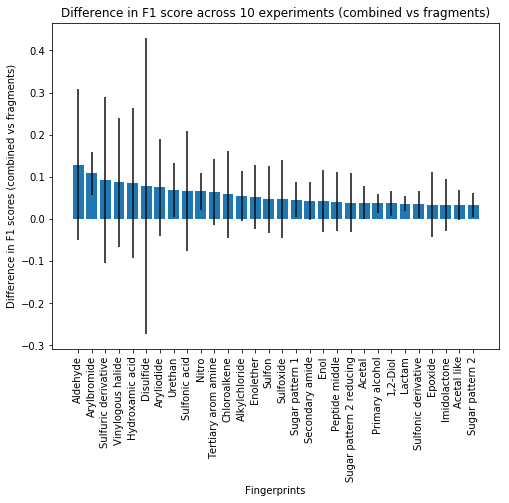

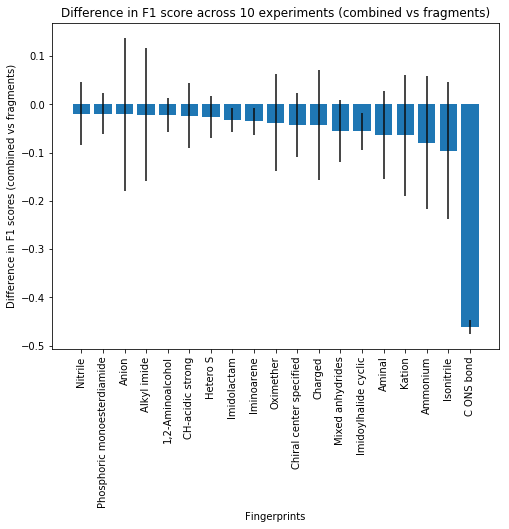

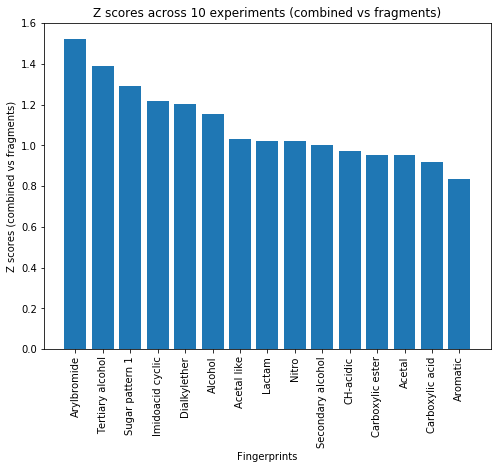

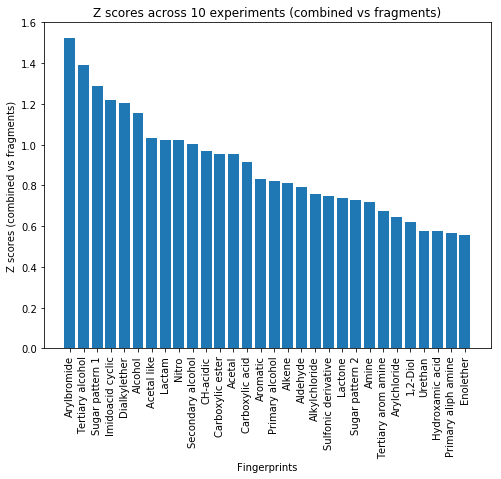

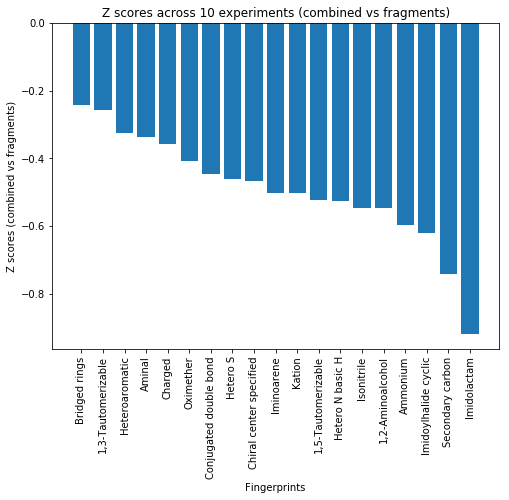

0 significantly different mean f1 scores
0 significantly positive difference
0 significantly negative difference


In [52]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (combined vs fragments)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (combined vs fragments)")
plt.show()

plt.title("Difference in F1 score across 10 experiments (combined vs fragments)")
plt.bar(f1_fingerprints[120:], f1_score_differences[120:], align='center', yerr=f1_std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(f1_z_fingerprints[:30], f1_z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs fragments)")
plt.bar(f1_z_fingerprints[120:], f1_z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs fragments)")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))

Compare combined with shifts only

AUC

In [54]:
difference_auc_filenames = ["exp_{}".format(i) for i in range(10)]
difference_auc_df = pd.DataFrame(0.0, index=difference_auc_filenames, columns=relevant_fingerprints, dtype=float)
differences = []
z_differences = []
pvalues = []

for i in combined_auc_df.columns:
    base_aucs = shift_auc_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = combined_auc_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_auc_df[i] = combined_auc_df[i] - shift_auc_df[i]
    difference = [difference for difference in difference_auc_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    differences.append((i, difference_mean, difference_std))
    z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    pvalues.append((i, t_test.pvalue))

In [55]:
differences.sort(key=lambda x: float(x[1]))
z_differences.sort(key=lambda x: float(x[1]))

differences.reverse()
z_differences.reverse()

In [56]:
ranked_pvalues_with_critical_value, max_pvalue_less_than_crit_rank = benjamini_fdr(pvalues)
stat_significant_results = ranked_pvalues_with_critical_value[:max_pvalue_less_than_crit_rank]
stat_significant_fingerprints = [result[0] for result in stat_significant_results]

In [57]:
fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                else fingerprint_names[fingerprint[0]]for fingerprint in differences]

z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in stat_significant_fingerprints 
                  else fingerprint_names[fingerprint[0]]for fingerprint in z_differences]

score_differences = [fingerprint[1] for fingerprint in differences]
z_scores = [fingerprint[1] for fingerprint in z_differences]

std_err = [fingerprint[2] for fingerprint in differences]

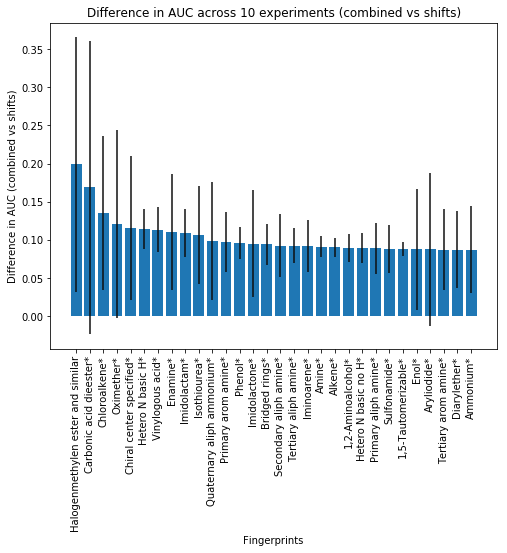

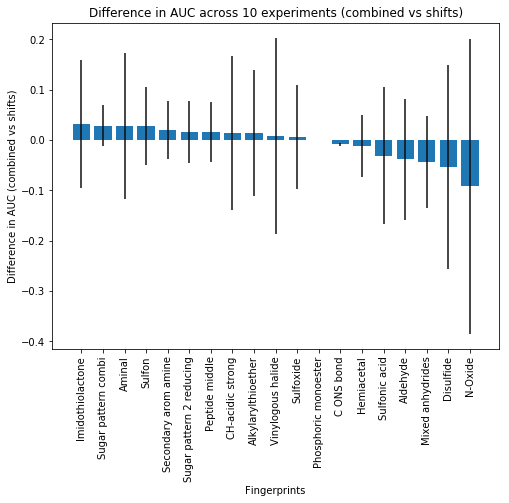

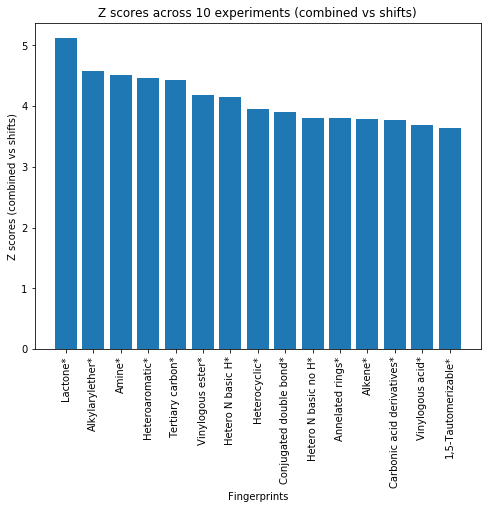

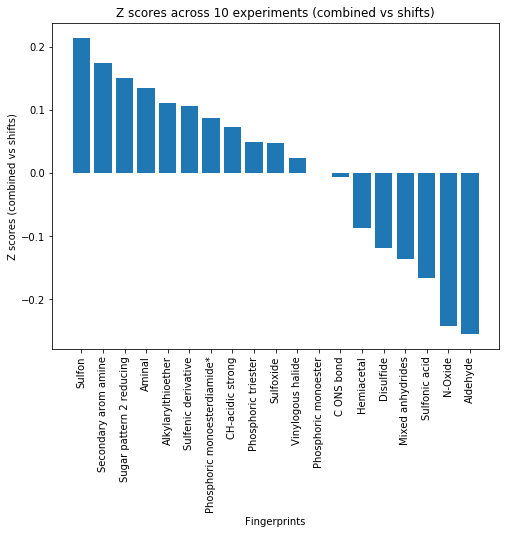

105 significantly different mean aucs
105 significantly positive difference
0 significantly negative difference


In [58]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)

plt.title("Difference in AUC across 10 experiments (combined vs shifts)")
plt.bar(fingerprints[:30], score_differences[:30], align='center', yerr=std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs shifts)")
plt.show()

plt.title("Difference in AUC across 10 experiments (combined vs shifts)")
plt.bar(fingerprints[120:], score_differences[120:], align='center', yerr=std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in AUC (combined vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shifts)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shifts)")
plt.bar(z_fingerprints[120:], z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shifts)")
plt.show()

positive_result = [result for result in differences if result[1] > 0 and result[0] in stat_significant_fingerprints]
negative_result = [result for result in differences if result[1] < 0 and result[0] in stat_significant_fingerprints]

print("{} significantly different mean aucs".format(max_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))


F1

In [59]:
difference_f1_filenames = ["exp_{}".format(i) for i in range(10)]
difference_f1_df = pd.DataFrame(0.0, index=difference_f1_filenames, columns=relevant_fingerprints, dtype=float)
f1_differences = []
f1_z_differences = []
f1_pvalues = []

for i in combined_f1_df.columns:
    base_aucs = shift_f1_df[i].tolist()
    base_mean = statistics.mean(base_aucs)
    base_std = statistics.stdev(base_aucs)
    
    exp_aucs = combined_f1_df[i].tolist()
    exp_mean = statistics.mean(exp_aucs)
    exp_std = statistics.stdev(exp_aucs)
    
    difference_f1_df[i] = combined_f1_df[i] - shift_f1_df[i]
    difference = [difference for difference in difference_f1_df[i].tolist() if difference != 0] # remove outliers\n",
    difference_std = 0.0
    difference_mean = 0.0
    z_score = 0.0
    
    if len(difference) > 1:
        difference_std = statistics.stdev(difference)
        difference_mean = statistics.mean(difference)       
        z_score = float(exp_mean - base_mean)/(((base_std**2)+(exp_std**2))**(float(1)/2))
    
    f1_differences.append((i, difference_mean, difference_std))
    f1_z_differences.append((i, z_score))
    t_test = wilcoxon(exp_aucs, base_aucs)
    f1_pvalues.append((i, t_test.pvalue))

In [60]:
f1_differences.sort(key=lambda x: float(x[1]))
f1_z_differences.sort(key=lambda x: float(x[1]))

f1_differences.reverse()
f1_z_differences.reverse()

In [61]:
ranked_f1_pvalues_with_critical_value, max_f1_pvalue_less_than_crit_rank = benjamini_fdr(f1_pvalues)
f1_stat_significant_results = ranked_f1_pvalues_with_critical_value[:max_f1_pvalue_less_than_crit_rank]
f1_stat_significant_fingerprints = [result[0] for result in f1_stat_significant_results]

In [62]:
f1_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                   else fingerprint_names[fingerprint[0]]for fingerprint in f1_differences]
f1_z_fingerprints = [fingerprint_names[fingerprint[0]] + "*" if fingerprint[0] in f1_stat_significant_fingerprints 
                     else fingerprint_names[fingerprint[0]]for fingerprint in f1_z_differences]

f1_score_differences = [f1_score[1] for f1_score in f1_differences]
f1_z_scores = [fingerprint[1] for fingerprint in f1_z_differences]

f1_std_err = [fingerprint[2] for fingerprint in f1_differences]

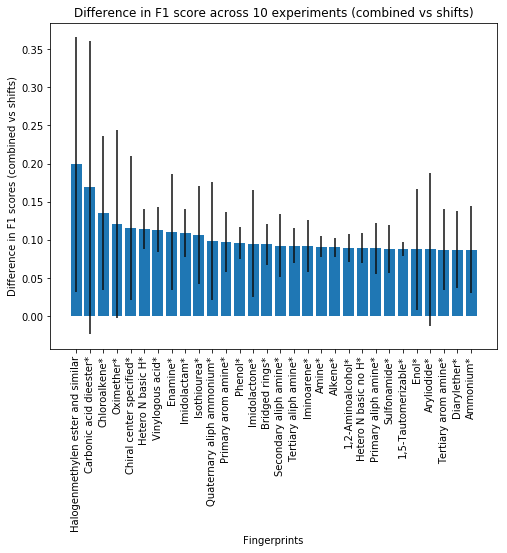

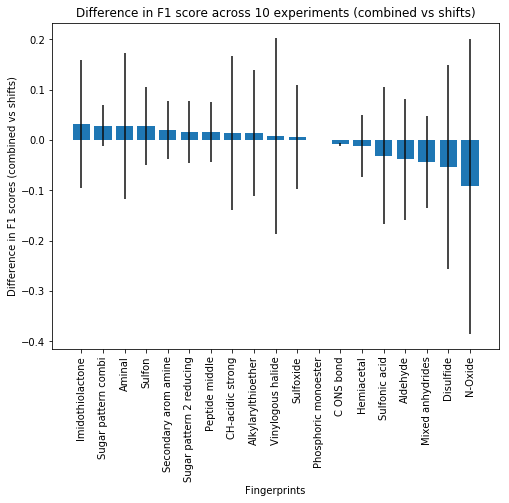

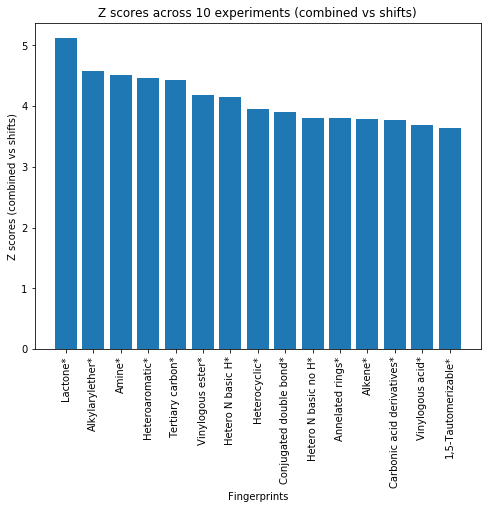

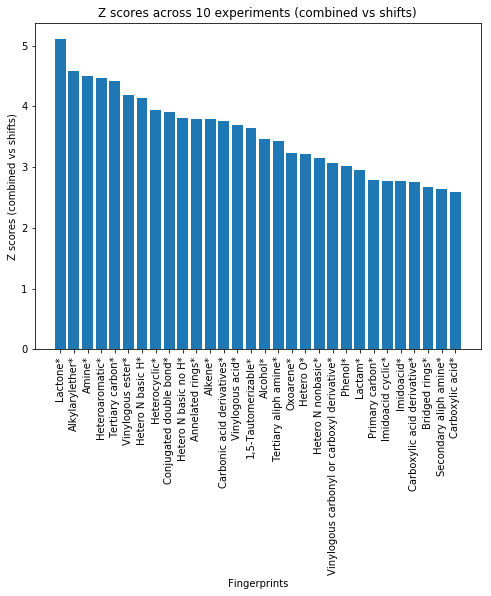

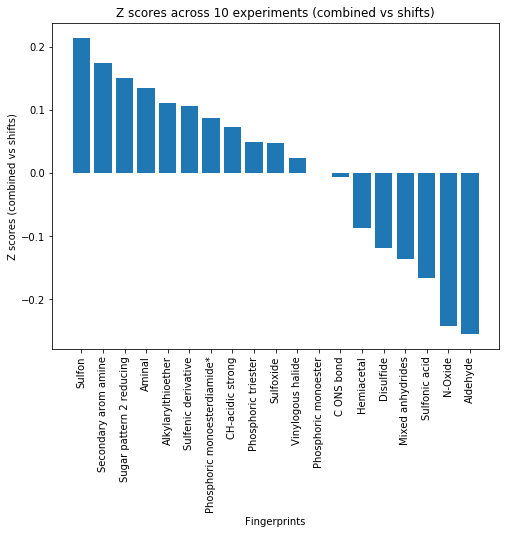

105 significantly different mean f1 scores
105 significantly positive difference
0 significantly negative difference


In [63]:
error_config = {'ecolor': '0.05'}
plt.rcParams['figure.figsize'] = (8,6)
plt.title("Difference in F1 score across 10 experiments (combined vs shifts)")
plt.bar(f1_fingerprints[:30], f1_score_differences[:30], align='center', yerr=f1_std_err[:30], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (combined vs shifts)")
plt.show()

plt.title("Difference in F1 score across 10 experiments (combined vs shifts)")
plt.bar(f1_fingerprints[120:], f1_score_differences[120:], align='center', yerr=f1_std_err[120:], error_kw=error_config)
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Difference in F1 scores (combined vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shifts)")
plt.bar(z_fingerprints[:15], z_scores[:15], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shifts)")
plt.bar(f1_z_fingerprints[:30], f1_z_scores[:30], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shifts)")
plt.show()

plt.title("Z scores across 10 experiments (combined vs shifts)")
plt.bar(f1_z_fingerprints[120:], f1_z_scores[120:], align='center')
plt.xticks(rotation=90)
plt.xlabel("Fingerprints")
plt.ylabel("Z scores (combined vs shifts)")
plt.show()

positive_result = [result for result in f1_differences if result[1] > 0 and result[0] in f1_stat_significant_fingerprints]
negative_result = [result for result in f1_differences if result[1] < 0 and result[0] in f1_stat_significant_fingerprints]

print("{} significantly different mean f1 scores".format(max_f1_pvalue_less_than_crit_rank))
print("{} significantly positive difference".format(len(positive_result)))
print("{} significantly negative difference".format(len(negative_result)))